In [2]:
from ml_toolkit import df_to_X_y
from ml_toolkit import plot_predictions

import os
import sys
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam


| Date                | Point_1_N_mean | PT100_Temperature_mean | Average_Global_Radiation_(1h) | Day sin          | Day cos          | Year sin       | Year cos       |
|---------------------|----------------|------------------------|-------------------------------|------------------|------------------|----------------|----------------|
| 2020-09-02 12:00:00 | 18.324186      | 16.261441              | 954.0                         | 7.392965e-12     | -1.000000e+00    | -0.961130      | -0.276097      |
| 2020-09-03 12:00:00 | 24.667922      | 16.858222              | 966.0                         | 3.094426e-12     | -1.000000e+00    | -0.965740      | -0.259512      |
| 2020-09-04 10:00:00 | -15.535099     | 14.256647              | 131.6                         | 5.000000e-01     | -8.660254e-01    | -0.969715      | -0.244241      |
| 2020-09-04 14:00:00 | -10.819921     | 14.687477              | 314.0                         | -5.000000e-01    | -8.660254e-01    | -0.970411      | -0.241458      |
| 2020-09-04 18:00:00 | -15.399971     | 13.874647              | 236.0                         | -1.000000e+00    | -1.359232e-12    | -0.971100      | -0.238673      |


# Loading data

In [3]:
git_folder = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', 'HeroysundBridge-ML'))
asset_folder = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', 'HeroysundBridge-ML-Assets'))

print("Path to git folder:", git_folder)
print("Path to asset folder:", asset_folder)

Path to git folder: c:\Users\erlih\repos\HeroysundBridge-ML
Path to asset folder: c:\Users\erlih\repos\HeroysundBridge-ML-Assets


**Opening file: \silver\combined with relevant columns**

In [4]:
df = pd.read_parquet(os.path.join(asset_folder, 'silver','combined_data_v01.parquet'))
df.index = pd.to_datetime(df['Date'], format='%Y%m%d%H')
df.to_csv(os.path.join(asset_folder, 'silver','inspection.csv'))

**Adding relevant time/dates columns**

C:\Users\erlih\AppData\Local\Temp\ipykernel_25076\1014083427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_dataset['seconds'] = model_dataset.index.map(pd.Timestamp.timestamp)
C:\Users\erlih\AppData\Local\Temp\ipykernel_25076\1014083427.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_dataset['Day sin'] = np.sin(model_dataset['seconds'] * (2 * np.pi / 86400))
C:\Users\erlih\AppData\Local\Temp\ipykernel_25076\1014083427.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy

,Point_1_N_mean,PT100_Temperature_mean,Average_Global_Radiation_(1h),Relative_Humidity(1h),Precipitation_(1h),Average_of_Mean_Wind_(1h),Day sin,Day cos,Year sin,Year cos,days_since_start
Date,,,,,,,,,,,
2020-09-02 12:00:00,18.324186,16.261441,954.0,49.0,0.1,0.9,7.392965e-12,-1.000000e+00,-0.961130,-0.276097,0
2020-09-03 12:00:00,24.667922,16.858222,966.0,45.0,0.0,3.5,3.094426e-12,-1.000000e+00,-0.965740,-0.259512,1
2020-09-04 10:00:00,-15.535099,14.256647,131.6,87.0,0.5,2.6,5.000000e-01,-8.660254e-01,-0.969715,-0.244241,1
2020-09-04 14:00:00,-10.819921,14.687477,314.0,86.0,0.2,4.0,-5.000000e-01,-8.660254e-01,-0.970411,-0.241458,2
2020-09-04 18:00:00,-15.399971,13.874647,236.0,74.0,0.0,1.3,-1.000000e+00,-1.359232e-12,-0.971100,-0.238673,2
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 18:00:00,-20.227229,-4.738139,-3.0,60.0,0.0,1.1,-1.000000e+00,-1.136945e-11,0.217723,0.976011,1215
2023-12-31 19:00:00,-19.488729,-4.625233,-3.0,59.0,0.0,1.3,-9.659258e-01,2.588190e-01,0.218423,0.975854,1215
2023-12-31 20:00:00,-21.503484,-4.645648,-2.9,57.0,0.0,1.3,-8.660254e-01,5.000000e-01,0.219123,0.975697,1215


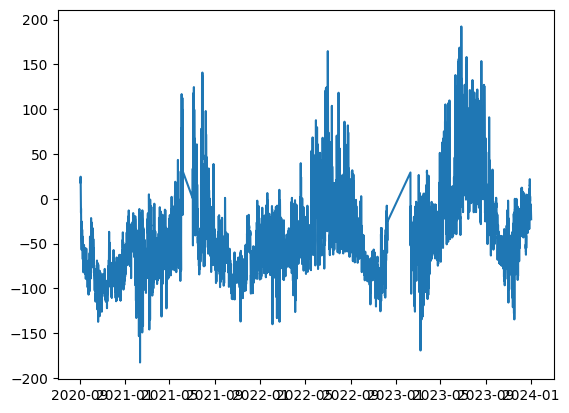

In [5]:
model_dataset = df[['Point_1_N_mean', 'PT100_Temperature_mean', 'Average_Global_Radiation_(1h)', 'Relative_Humidity(1h)', 'Precipitation_(1h)', 'Average_of_Mean_Wind_(1h)']]
model_dataset['seconds'] = model_dataset.index.map(pd.Timestamp.timestamp)
model_dataset['Day sin'] = np.sin(model_dataset['seconds'] * (2 * np.pi / 86400))
model_dataset['Day cos'] = np.cos(model_dataset['seconds'] * (2 * np.pi / 86400))
model_dataset['Year sin'] = np.sin(model_dataset['seconds'] * (2 * np.pi / 31536000))
model_dataset['Year cos'] = np.cos(model_dataset['seconds'] * (2 * np.pi / 31536000))
model_dataset['days_since_start'] = (model_dataset.index - model_dataset.index[0]).days
model_dataset.drop(columns=['seconds'], inplace=True)
display(model_dataset)
plt.plot(model_dataset.index, model_dataset['Point_1_N_mean'])

# Train-, val- and testing split +++ Scaling

In [6]:
window_size = 5

dataset_size = len(model_dataset)
training_split = int(0.72 * dataset_size)
validation_split = int(0.18 * dataset_size)
test_split = dataset_size - training_split - validation_split
print(f"Training split: {training_split}, Validation split: {validation_split}, Test split: {test_split}")
assert training_split + validation_split + test_split == dataset_size, "Invalid split sizes"

Training split: 19304, Validation split: 4826, Test split: 2682


**Assigning labels and targets - x- and y- train,-val and -test**

In [7]:
X, y = df_to_X_y(model_dataset, window_size)
print(X.shape, y.shape)

# Splitting the data into training, validation and test sets
X_train, y_train = X[:training_split], y[:training_split]
X_valid, y_valid = X[training_split:(training_split + validation_split)], y[training_split:(training_split + validation_split)]
X_test, y_test = X[-test_split:], y[-test_split:]
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(26807, 5, 10) (26807,)
(19304, 5, 10) (19304,) (4826, 5, 10) (4826,) (2682, 5, 10) (2682,)


**Normlaization**

In [8]:
# Reshape to 2D (Normalisation requires 2D input)
X_train_2D = np.reshape(X_train, (X_train.shape[0] * X_train.shape[1], X_train.shape[2]))
X_valid_2D = np.reshape(X_valid, (X_valid.shape[0] * X_valid.shape[1], X_valid.shape[2]))
X_test_2D = np.reshape(X_test, (X_test.shape[0] * X_test.shape[1], X_test.shape[2]))

# Apply scaling
scaler_x = StandardScaler()
X_train_scaled_2D = scaler_x.fit_transform(X_train_2D)
X_valid_scaled_2D = scaler_x.transform(X_valid_2D)
X_test_scaled_2D = scaler_x.transform(X_test_2D)

# Reshape back to 3D
X_train_scaled = np.reshape(X_train_scaled_2D, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_valid_scaled = np.reshape(X_valid_scaled_2D, (X_valid.shape[0], X_valid.shape[1], X_valid.shape[2]))
X_test_scaled = np.reshape(X_test_scaled_2D, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_valid_scaled = scaler_y.transform(y_valid.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# LSTM Model 2

In [9]:
model_name = 'gru_model_1'
batch_size = 128
epochs = 100
learning_rate = 0.0001
patience = 10
verbose = 0
saving_frequency = 8

In [10]:
model = Sequential()
model.add(InputLayer((window_size, (len(model_dataset.columns)-1))))
model.add(GRU(64, return_sequences=True))
model.add(GRU(64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 64)             14592     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 40081 (156.57 KB)
Trainable params: 40081 (156.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
cp = ModelCheckpoint(os.path.join(asset_folder, 'gold', str(model_name)), save_best_only=True, mode='auto', verbose=verbose)
es = EarlyStopping(monitor='val_loss', patience=patience, mode='auto', verbose=verbose)
model.compile(optimizer=Adam(learning_rate), loss=mean_absolute_error, metrics=['mae'])
history = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_valid_scaled, y_valid_scaled), epochs=epochs, batch_size=batch_size, callbacks=[es,cp], verbose=verbose) 



INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_2\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_2\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_2\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_2\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_2\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_2\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_2\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_2\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_2\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_2\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_2\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\lstm_model_2\assets


**Visualization of ML-metrics**

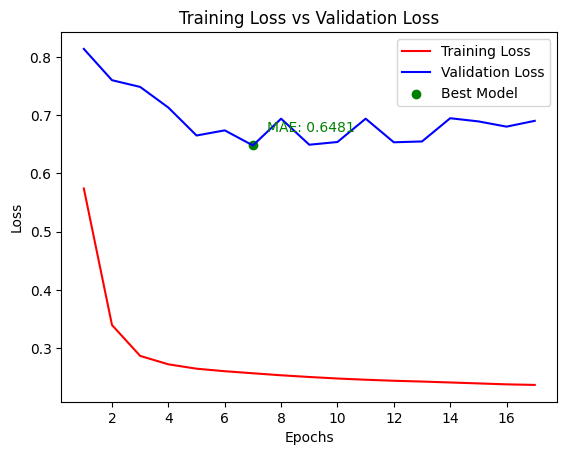

In [12]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Get the index of the best model
best_model_index = np.argmin(val_loss)

# Plot the training loss vs validation loss
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.scatter(best_model_index + 1, val_loss[best_model_index], color='g', label='Best Model')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the MAE value of the best model
best_model_mae = val_loss[best_model_index]
plt.annotate(f'MAE: {best_model_mae:.4f}', (best_model_index + 1, best_model_mae), xytext=(10, 10),
             textcoords='offset points', color='g')

plt.show()

### Predictions

84/84 [==============================] - 1s 2ms/step


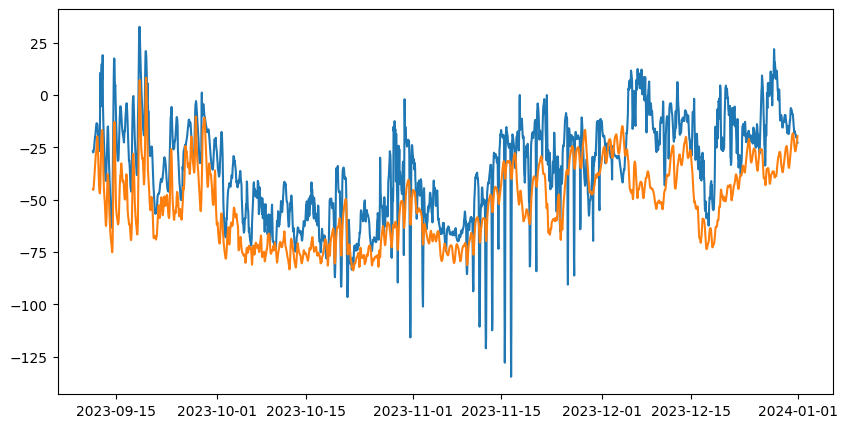

MSE: 533.2589721679688
MAE: 19.427350997924805


,Predictions,Actuals
0,-44.867771,-26.868450
1,-45.313107,-27.434437
2,-44.892101,-27.154563
3,-43.652279,-26.173874
4,-41.635223,-25.681637
...,...,...
2677,-24.202068,-20.227229
2678,-23.097952,-19.488729
2679,-21.928005,-21.503484
2680,-20.819738,-22.667015


In [13]:
model_file_path = os.path.join(asset_folder, 'gold', model_name)
model = load_model(model_file_path)
plot_predictions(model_dataset, test_split, model, X_test_scaled, y_test, start=0, end=test_split, scaler=scaler_y)